# Neural Network Regression for Acute Myeloid Leukemia Survival
CS 7097: Introduction to Functional Genomics | Q Paper<br>
Frazier N. Baker<sup>1,2,\*</sup><br>
<sub>1 Department of Electrical Engineering and Computer Science, University of Cincinnati, 2901 Woodside Drive 
Cincinnati, Ohio, USA 45221</sub><br>
<sub>2 Center for Autoimmune Genomics and Etiology, Cincinnati Children's Hospital Medical Center, 3333 Burnet Avenue, 
Cincinnati, Ohio, USA 45229</sub><br>
<sub>\*To whom correspondence should be addressed</sub>

## Introduction
- Gene expression profiles of tumours have been shown to convey information about clinical outcomes for AML patients [Nature Paper][FGT5 Paper]
- Subtyping AML often requires examining cytogenetic features and mutations [European LeukemiaNet classification].  Some subtypes are strongly correlated to overall survival.
- Even so, the TCGA data[TCGA NEJM Paper] suggests that understanding AML survival requires a more nuanced look at the tumor and the patient [FGT5 Paper, Survival curves].


## Hypothesis
- Given RNA expression levels from a primary tumor sample and other patient metadata, we can train a neural network to estimate overall survival (in months).

In [0]:
import random
import pandas as pd
import numpy as np
import sklearn.metrics as skmet
import scipy.stats as stats
from tensorflow.keras import layers, models, callbacks, optimizers
import matplotlib.pyplot as plt
import tensorflow.keras.utils as utils

In [0]:
trained = {}

In [0]:
token = "1qik9mn9" #@param { type: "string" }
!curl -o data.txt https://filebin.net/0mp8irqjjmcmt04o/data_RNA_Seq_v2_mRNA_median_Zscores.txt?t={token}
!curl -o patient.txt https://filebin.net/0mp8irqjjmcmt04o/data_clinical_patient.txt?t={token}
!curl -o genelist.txt https://filebin.net/0mp8irqjjmcmt04o/genelist.txt?t={token}
!curl -o Muvasapaj_best_1000.hdf5 https://filebin.net/0mp8irqjjmcmt04o/Muvasapaj_best_1000.hdf5?t={token}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.7M  100 24.7M    0     0  9850k      0  0:00:02  0:00:02 --:--:-- 9846k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39001  100 39001    0     0  59182      0 --:--:-- --:--:-- --:--:-- 59182
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 15979  100 15979    0     0  24210      0 --:--:-- --:--:-- --:--:-- 24173
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45.2M  100 45.2M    0     0  12.5M      0  0:00:03  0:00:03 --:--:-- 12.5M


In [0]:
def generate_name(last=None):
  consonants = list("BCDFGJKLMNPRSTVWZ")
  vowels = list("AEIOU")
  special = ["QU", "H", "Y", "SH", "CH", "TH"]
  length = random.choice([2,4,5,6,7,8,9,10])
  letters = consonants+vowels+special
  new = random.choice(letters)
  for x in range(length):
      if new[len(new)-1] in consonants+special:
          new += random.choice(vowels)
      else:
          new += random.choice([""]*500+special[2:])
          new += random.choice(consonants*3+vowels)
  l = new.lower().capitalize()
  return l

In [0]:
genelist = []
with open("genelist.txt","r") as g:
  genelist = [x.replace("\n","").replace(" ","") for x in g]

data = pd.read_csv("data.txt",sep="\t",index_col=1)

patient = pd.read_csv("patient.txt",sep="\t",index_col=0, skiprows=4)
survival = patient["OS_MONTHS"]
age = patient["AGE"]
wbc = patient["WBC"]

In [0]:
print(data.shape)
where1 =[x in genelist for x in data["Hugo_Symbol"]]
where = np.array([where1 for i in range(data.shape[1])]).transpose()
data = data.where(where)
data_t = data.transpose()
data_t = data_t.drop(["Hugo_Symbol"], axis=0).dropna(1).rename(index=lambda x: x.replace("-03",""))
data_t = pd.concat([data_t, survival], axis=1).dropna(0)

In [279]:
survival[patient["OS_STATUS"]=="LIVING"] = 24
survival[patient["OS_STATUS"]=="LIVING"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


PATIENT_ID
TCGA-AB-2804    24.0
TCGA-AB-2819    24.0
TCGA-AB-2828    24.0
TCGA-AB-2862    24.0
TCGA-AB-2872    24.0
TCGA-AB-2875    24.0
TCGA-AB-2881    24.0
TCGA-AB-2886    24.0
TCGA-AB-2888    24.0
TCGA-AB-2889    24.0
TCGA-AB-2892    24.0
TCGA-AB-2897    24.0
TCGA-AB-2905    24.0
TCGA-AB-2906    24.0
TCGA-AB-2914    24.0
TCGA-AB-2942    24.0
TCGA-AB-2950    24.0
TCGA-AB-2954    24.0
TCGA-AB-2957    24.0
TCGA-AB-2980    24.0
TCGA-AB-2982    24.0
TCGA-AB-2991    24.0
TCGA-AB-2994    24.0
TCGA-AB-2999    24.0
TCGA-AB-3001    24.0
TCGA-AB-3007    24.0
TCGA-AB-3012    24.0
TCGA-AB-2808    24.0
TCGA-AB-2835    24.0
TCGA-AB-2869    24.0
                ... 
TCGA-AB-2916    24.0
TCGA-AB-2919    24.0
TCGA-AB-2924    24.0
TCGA-AB-2932    24.0
TCGA-AB-2934    24.0
TCGA-AB-2936    24.0
TCGA-AB-2947    24.0
TCGA-AB-2964    24.0
TCGA-AB-2967    24.0
TCGA-AB-2969    24.0
TCGA-AB-2978    24.0
TCGA-AB-2979    24.0
TCGA-AB-2981    24.0
TCGA-AB-2984    24.0
TCGA-AB-2990    24.0
TCGA-AB-2995    24.0
TC

In [280]:
train = data_t.sample(frac=0.7, random_state=7)
trainx = train.drop("OS_MONTHS", axis=1)
trainy = np.clip(train["OS_MONTHS"],0.0,24.0)
print("TrainX dimensions: "+str(trainx.shape))
print("TrainY dimensions: "+str(trainy.shape))
test = data_t.drop(train.index.values,axis=0)
testx = test.drop("OS_MONTHS", axis=1)
testy = np.clip(test["OS_MONTHS"],0.0,24.0)
print("TestX dimensions: "+str(testx.shape))
print("TestY dimensions: "+str(testy.shape))
print("First of each: "+str([trainy[0],testy[0]]))
print("Mean of Training:\t%0.2f\nMean of Test:\t\t%0.2f" % (np.mean(trainy),np.mean(testy)))
print("Median of Training:\t%0.2f\nMedian of Test:\t\t%0.2f" % (np.median(trainy),np.median(testy)))

TrainX dimensions: (121, 1929)
TrainY dimensions: (121,)
TestX dimensions: (52, 1929)
TestY dimensions: (52,)
First of each: [24.0, 24.0]
Mean of Training:	15.24
Mean of Test:		14.51
Median of Training:	18.10
Median of Test:		14.80


In [0]:
width = "1024" #@param [16,32,64,128,256,512,1024,4096,8192,16384]
activation = "relu" #@param ["sigmoid", "tanh", "relu"]
lr = 0.0001 #@param ["0.001", "0.01", "0.1", "0.0001"] {type:"raw"}
bs = 32 #@param {type:"slider", min:1, max:96, step:1}


In [0]:
model = models.Sequential()
model.add(layers.Dense(1024,activation="sigmoid", input_shape=(1929,)))
model.add(layers.Dense(1,activation="relu"))
model.compile(optimizer=optimizers.Adam(lr*5),loss='mean_squared_error')

In [294]:
name = generate_name()
print(name)

model.fit(trainx,trainy,validation_split=0.2, batch_size=bs, epochs=3000, verbose=1, callbacks=[callbacks.ModelCheckpoint("%s_best_1000.hdf5" % name, save_best_only=True,period=1,mode='min')])
#model.fit(trainx,trainy,validation_split=0.2, batch_size=bs, epochs=1000, callbacks=[callbacks.EarlyStopping("val_loss",patience=20),callbacks.ModelCheckpoint("%s_best_large_batch.hdf5" % name, save_best_only=True,period=1,mode='min')])

Fozecelo
Train on 96 samples, validate on 25 samples
Epoch 1/3000
96/96 [==============================] - 16s 166ms/step - loss: 293.9600 - val_loss: 274.0148
Epoch 2/3000
96/96 [==============================] - 0s 2ms/step - loss: 242.0437 - val_loss: 232.5577
Epoch 3/3000
96/96 [==============================] - 1s 11ms/step - loss: 204.4009 - val_loss: 208.1930
Epoch 4/3000
96/96 [==============================] - 1s 11ms/step - loss: 180.7307 - val_loss: 192.6621
Epoch 5/3000
96/96 [==============================] - 1s 11ms/step - loss: 158.1678 - val_loss: 184.9912
Epoch 6/3000
96/96 [==============================] - 0s 3ms/step - loss: 143.3056 - val_loss: 178.5514
Epoch 7/3000
96/96 [==============================] - 0s 2ms/step - loss: 129.9723 - val_loss: 174.2457
Epoch 8/3000
96/96 [==============================] - 1s 12ms/step - loss: 120.5550 - val_loss: 170.8181
Epoch 9/3000
96/96 [==============================] - 1s 11ms/step - loss: 110.4867 - val_loss: 169.6042
Epo

Fozecelo
SpearmanrResult(correlation=0.5272979779454615, pvalue=5.9082362709615565e-05)
7.112711862589304


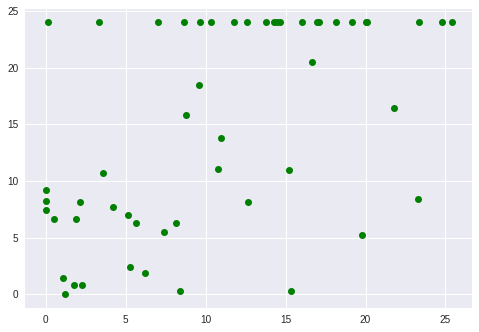

In [296]:
print(name)
best = models.load_model("%s_best_1000.hdf5" % name)
output = np.squeeze(best.predict(testx))
r = stats.spearmanr(output,testy)
print(r)
print(np.mean(np.abs(output-testy)))
trained[name] = (best, r)
plt.plot(output,testy,'go')
plt.plot([0,0],[24,24], 'r-')
# Muvasapaj correlation=0.5039400307065084, pvalue=0.00013968924786221507; mean absolute error: 7.725300449161575 months

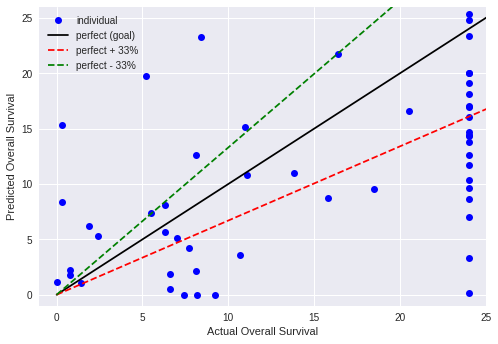

In [322]:

plt.plot(testy, output,'bo')
trueline = np.array(range(0,30,1))
plt.plot(trueline,trueline,'k-')
plt.plot(trueline,trueline*0.67,'r--')
plt.plot(trueline,trueline*1.33,'g--')
plt.xlim(-1,25)
plt.ylim(-1,26)
plt.xlabel("Actual Overall Survival")
plt.ylabel("Predicted Overall Survival")
plt.legend(['individual','perfect (goal)', 'perfect + 33%', 'perfect - 33%'])
plt.savefig("expression_fig.png", dpi=600)

In [0]:
files.download("expression_fig.png")
files.download("Fozecelo_best_1000.hdf5")

In [320]:
print(np.mean(output - testy))
print(np.mean(np.abs(output-testy)))
print(np.mean(np.square(output-testy)))


-3.9069148423006905
7.112711862589304
80.28127506452941


{'boxes': [<matplotlib.lines.Line2D at 0x7f232808b5c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f23280900b8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f2328015240>,
 'means': [<matplotlib.lines.Line2D at 0x7f2328090dd8>,
 'medians': [<matplotlib.lines.Line2D at 0x7f2328090978>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f232808b748>,
  <matplotlib.lines.Line2D at 0x7f2328026358>]}

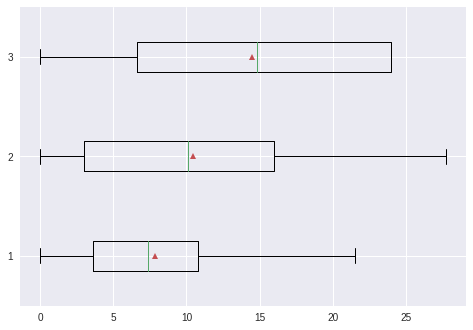

In [287]:
plt.boxplot([np.abs(output-testy), output, testy], showmeans=True, showfliers=True, vert=False)

In [167]:
stats.spearmanr(output, testy)

SpearmanrResult(correlation=0.519615432031316, pvalue=7.895670597941503e-05)

### Training Clinical Data Models

In [0]:
sex = patient["SEX"] == "FEMALE"
blast = patient["PB_BLAST_PERCENTAGE"]
blast = blast.fillna(0) # Fill with 0

In [0]:
def zscore(x):
  return (x-np.mean(x))/np.sqrt(np.var(x))
age = zscore(age)
wbc = zscore(wbc)
blast = blast/100

In [246]:
data_t2 = data.transpose()
data_t2 = data_t2.drop(["Hugo_Symbol"], axis=0).dropna(1).rename(index=lambda x: x.replace("-03",""))
data_t2 = pd.concat([data_t2, survival, age, wbc, sex, blast], axis=1).dropna(0)[["WBC","AGE","PB_BLAST_PERCENTAGE","SEX","OS_MONTHS"]]
train2 = data_t2.sample(frac=0.7, random_state=7)
trainx2 = train2.drop("OS_MONTHS", axis=1)
trainy2 = np.clip(train["OS_MONTHS"],0.0,24.0)
print("TrainX dimensions: "+str(trainx2.shape))
print("TrainY dimensions: "+str(trainy2.shape))
test2 = data_t2.drop(train.index.values,axis=0)
testx2 = test2.drop("OS_MONTHS", axis=1)
testy2 = np.clip(test["OS_MONTHS"],0.0,24.0)
print("TestX dimensions: "+str(testx2.shape))
print("TestY dimensions: "+str(testy2.shape))
print("First of each: "+str([trainy2[0],testy2[0]]))
print("Mean of Training:\t%0.2f\nMean of Test:\t\t%0.2f" % (np.mean(trainy2),np.mean(testy2)))
print("Median of Training:\t%0.2f\nMedian of Test:\t\t%0.2f" % (np.median(trainy2),np.median(testy2)))

TrainX dimensions: (121, 4)
TrainY dimensions: (121,)
TestX dimensions: (52, 4)
TestY dimensions: (52,)
First of each: [24.0, 24.0]
Mean of Training:	15.24
Mean of Test:		14.51
Median of Training:	18.10
Median of Test:		14.80


In [0]:
cname = generate_name()
print(cname)

cmodel.fit(trainx2,trainy2,validation_split=0.2, batch_size=bs, epochs=5000, verbose=1, callbacks=[callbacks.ModelCheckpoint("%s_best_1000.hdf5" % cname, save_best_only=True,period=1,mode='min')])

Icuou


NameError: ignored

Chalobouva
SpearmanrResult(correlation=-0.18307764402699528, pvalue=0.19390590442772382)
9.562056965094346


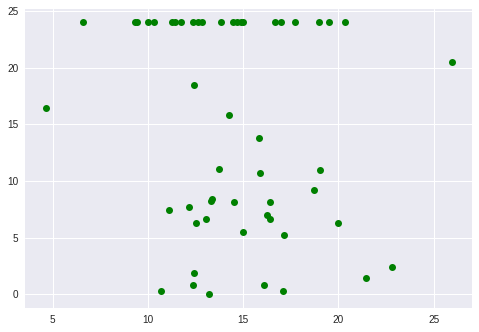

In [0]:
#name = "Thivutari" #@param {type:'string'})
print(cname)
cbest = models.load_model("%s_best_1000.hdf5" % cname)
coutput = np.squeeze(cbest.predict(testx2))
cr = stats.spearmanr(coutput,testy2)
print(cr)
print(np.mean(np.abs(coutput-testy2)))
trained[cname] = (cbest, cr)
plt.plot(coutput,testy2,'go')
# clinical_alone: correlation=-0.18307764402699528, pvalue=0.19390590442772382

### Concatenating Models

In [170]:
trained

{'Acikurab': (<tensorflow.python.keras.engine.sequential.Sequential at 0x7f233800a9e8>,
  SpearmanrResult(correlation=0.09791079434380902, pvalue=0.48985247198633586)),
 'Chab': (<tensorflow.python.keras.engine.sequential.Sequential at 0x7f233800a9e8>,
  SpearmanrResult(correlation=0.1706445272849243, pvalue=0.22646415317142085)),
 'Cosaniluliu': (<tensorflow.python.keras.engine.sequential.Sequential at 0x7f2334b7a470>,
  SpearmanrResult(correlation=0.3447969696506472, pvalue=0.012307274188006687)),
 'Gafobucev': (<tensorflow.python.keras.engine.sequential.Sequential at 0x7f23371ca7b8>,
  SpearmanrResult(correlation=0.39493750207360956, pvalue=0.003761439724212353)),
 'Girefezefo': (<tensorflow.python.keras.engine.sequential.Sequential at 0x7f2333d470b8>,
  SpearmanrResult(correlation=0.519615432031316, pvalue=7.895670597941503e-05)),
 'Isedotola': (<tensorflow.python.keras.engine.sequential.Sequential at 0x7f23384f51d0>,
  SpearmanrResult(correlation=-0.014786528125391565, pvalue=0.91

data.txt  genelist.txt	patient.txt  sample_data


In [0]:
from tensorflow.keras import regularizers
from google.colab import files

In [0]:
files.download("Girefezefo_best_1000.hdf5")

In [0]:
expression_model = models.load_model("Fozecelo_best_1000.hdf5")

In [0]:
for l in expression_model.layers:
  l.trainable = False
ginput = layers.Input(shape=(1929,), name="expression_input")
clininput = layers.Input(shape=(4,), name="clinical_input")
gmodel = expression_model(ginput)
concat = layers.concatenate([gmodel, clininput])
consensus = layers.Dense(16, activation="sigmoid")(concat)
consensus = layers.Dense(1, activation="relu")(consensus)
conmodel = models.Model(inputs=[ginput, clininput], outputs=consensus)

In [0]:
conmodel.compile(optimizer=optimizers.Adam(lr*10),loss='mean_squared_error')

In [328]:
conmodel.fit(x={"expression_input": trainx, "clinical_input": trainx2}, y=trainy, validation_split=0.2, batch_size=bs, epochs=1000, callbacks=[callbacks.ModelCheckpoint("consensus_best2.hdf5", save_best_only=True, monitor='val_loss')])

Train on 96 samples, validate on 25 samples
Epoch 1/1000
96/96 [==============================] - 19s 200ms/step - loss: 308.5655 - val_loss: 328.0831
Epoch 2/1000
96/96 [==============================] - 0s 4ms/step - loss: 307.4902 - val_loss: 326.8285
Epoch 3/1000
96/96 [==============================] - 0s 4ms/step - loss: 306.3378 - val_loss: 325.5377
Epoch 4/1000
96/96 [==============================] - 0s 4ms/step - loss: 305.1507 - val_loss: 324.2386
Epoch 5/1000
96/96 [==============================] - 0s 4ms/step - loss: 304.0315 - val_loss: 322.9349
Epoch 6/1000
96/96 [==============================] - 0s 4ms/step - loss: 302.7849 - val_loss: 321.6508
Epoch 7/1000
96/96 [==============================] - 0s 4ms/step - loss: 301.6178 - val_loss: 320.3692
Epoch 8/1000
96/96 [==============================] - 0s 4ms/step - loss: 300.4911 - val_loss: 319.0887
Epoch 9/1000
96/96 [==============================] - 0s 4ms/step - loss: 299.3096 - val_loss: 317.8200
Epoch 10/1000
96/

SpearmanrResult(correlation=0.5450261862437018, pvalue=2.944141979809372e-05)
6.98919736467875


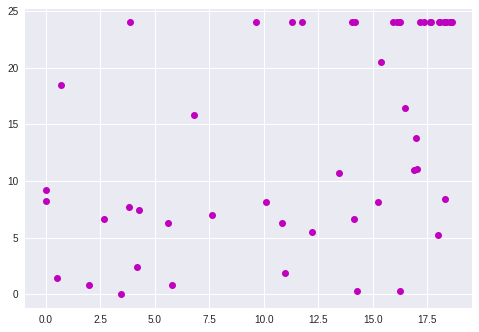

In [329]:
con_best = models.load_model("consensus_best.hdf5")
con_output = np.squeeze(con_best.predict({"expression_input": testx, "clinical_input": testx2}))
con_r = stats.spearmanr(con_output,testy)
print(con_r)
print(np.mean(np.abs(con_output-testy)))
trained["consensus"] = (con_best, con_r)
plt.plot(con_output,testy,'mo')

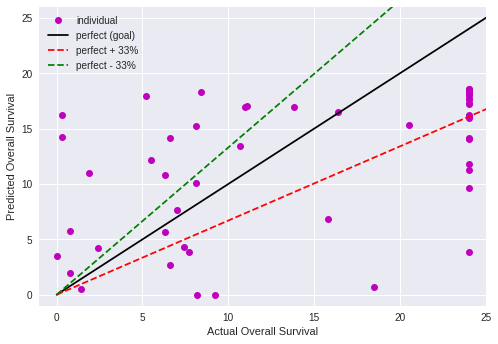

In [336]:
plt.plot(testy, con_output,'mo')
trueline = np.array(range(0,30,1))
plt.plot(trueline,trueline,'k-')
plt.plot(trueline,trueline*0.67,'r--')
plt.plot(trueline,trueline*1.33,'g--')
plt.xlim(-1,25)
plt.ylim(-1,26)
plt.xlabel("Actual Overall Survival")
plt.ylabel("Predicted Overall Survival")
plt.legend(['individual','perfect (goal)', 'perfect + 33%', 'perfect - 33%'])
plt.savefig("consensus_fig.png", dpi=600)

In [337]:
print(np.mean(con_output - testy))
print(np.mean(np.abs(con_output-testy)))
print(np.mean(np.square(con_output-testy)))

-2.390771506841366
6.98919736467875
67.54856570853349


In [261]:
!ls

Acikurab_best_1000.hdf5     Hun_best_1000.hdf5
Chab_best_1000.hdf5	    Isedotola_best_1000.hdf5
consensus_best2.hdf5	    Izerirofil_best_1000.hdf5
consensus_best.hdf5	    Jem_best_1000.hdf5
Cosaniluliu_best_1000.hdf5  Kol_best_1000.hdf5
Dapas_best_1000.hdf5	    Muvasapaj_best_1000.hdf5
data.txt		    Oto_best_1000.hdf5
Demewua_best_1000.hdf5	    patient.txt
Fifut_best_1000.hdf5	    sample_data
Gafobucev_best_1000.hdf5    Sapubobes_best_1000.hdf5
genelist.txt		    Ugetad_best_1000.hdf5
Girefezefo_best_1000.hdf5   Umaza_best_1000.hdf5
Herisofobac_best_1000.hdf5


In [0]:
#files.download("consensus_best.hdf5")
files.download("consensus_fig.png")

In [348]:
sum(np.array(con_output < testy*1.33, dtype='float32') * np.array(con_output > testy*0.67, dtype='float32'))

22.0